In [1]:
# Import Dependencies
import numpy as np
from keras.datasets import cifar10
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Conv2D, Dropout, MaxPool2D, Flatten, Dense
import matplotlib.pyplot as plt
%matplotlib inline

c:\users\ad1026858\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15318846389323379946
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1494109388
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1907268119059587131
physical_device_desc: "device: 0, name: Quadro M1000M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
# Import Dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [5]:
# Normalize Features
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [6]:
num_classes = len(np.unique(y_train))

In [7]:
# One Hot Encoding Labels
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [8]:
# Train Validation Split
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=101)

In [10]:
len(X_train), len(y_train)

(40000, 40000)

In [11]:
len(X_val), len(y_val)

(10000, 10000)

In [12]:
X_train.shape, y_train.shape

((40000, 32, 32, 3), (40000, 10))

In [13]:
X_val.shape, y_val.shape

((10000, 32, 32, 3), (10000, 10))

### Augmented Image Generator

In [14]:
from keras.preprocessing.image import ImageDataGenerator

In [15]:
# Augmented Training Data Generator
trainDataGen = ImageDataGenerator(width_shift_range=0.1, horizontal_flip=True, height_shift_range=0.1)

# Augmented Validation Data Generator
valDataGen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

In [16]:
# Fit Data Generator on Dataset
trainDataGen.fit(X_train)
valDataGen.fit(X_val)

In [17]:
# 10 random images
n = np.random.randint(0,len(X_train), 10)

In [18]:
n

array([33089, 10247,  2054,   120, 18943, 18687,  7710, 17895,   824,
       34089])

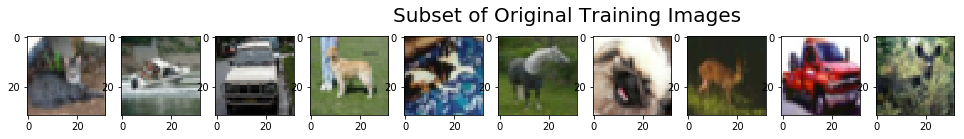

In [19]:
fig = plt.figure(figsize=(20,2))
for i in range(0, len(n)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(X_train[n[i]])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

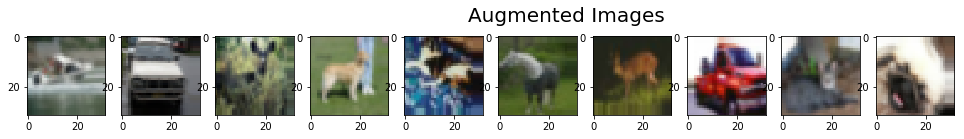

In [20]:
fig = plt.figure(figsize=(20,2))
for x_batch in trainDataGen.flow(X_train[n[:]], batch_size=12):
    for i in range(0, 10):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

### CNN Model Architecture

In [21]:
# Make the CNN Model

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='elu', input_shape=(X_train.shape[1:])))
model.add(MaxPool2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='elu'))
model.add(MaxPool2D(pool_size=2))
#model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='elu'))
model.add(MaxPool2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='elu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
__________

In [22]:
# Compile the Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
from keras.callbacks import ModelCheckpoint   

batch_size = 32

checkpoint = ModelCheckpoint(filepath='./cifar_aug_cnn.hdf5', verbose=1 ,save_best_only=True)

hist = model.fit_generator(trainDataGen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=100, verbose=2, callbacks=[checkpoint],
                    validation_data=valDataGen.flow(X_val, y_val, batch_size=batch_size),
                    validation_steps=X_val.shape[0] // batch_size)

Epoch 1/100
 - 22s - loss: 1.6502 - acc: 0.4073 - val_loss: 1.4059 - val_acc: 0.5071

Epoch 00001: val_loss improved from inf to 1.40587, saving model to ./cifar_aug_cnn.hdf5
Epoch 2/100
 - 20s - loss: 1.4093 - acc: 0.5008 - val_loss: 1.2926 - val_acc: 0.5446

Epoch 00002: val_loss improved from 1.40587 to 1.29258, saving model to ./cifar_aug_cnn.hdf5
Epoch 3/100
 - 19s - loss: 1.3283 - acc: 0.5329 - val_loss: 1.2582 - val_acc: 0.5549

Epoch 00003: val_loss improved from 1.29258 to 1.25817, saving model to ./cifar_aug_cnn.hdf5
Epoch 4/100
 - 20s - loss: 1.2862 - acc: 0.5442 - val_loss: 1.1512 - val_acc: 0.5996

Epoch 00004: val_loss improved from 1.25817 to 1.15117, saving model to ./cifar_aug_cnn.hdf5
Epoch 5/100
 - 20s - loss: 1.2476 - acc: 0.5572 - val_loss: 1.2052 - val_acc: 0.5801

Epoch 00005: val_loss did not improve
Epoch 6/100
 - 20s - loss: 1.2273 - acc: 0.5664 - val_loss: 1.1057 - val_acc: 0.6064

Epoch 00006: val_loss improved from 1.15117 to 1.10570, saving model to ./cifa

 - 19s - loss: 0.8838 - acc: 0.6933 - val_loss: 0.7266 - val_acc: 0.7532

Epoch 00056: val_loss improved from 0.73097 to 0.72658, saving model to ./cifar_aug_cnn.hdf5
Epoch 57/100
 - 23s - loss: 0.8924 - acc: 0.6897 - val_loss: 0.7246 - val_acc: 0.7515

Epoch 00057: val_loss improved from 0.72658 to 0.72465, saving model to ./cifar_aug_cnn.hdf5
Epoch 58/100
 - 19s - loss: 0.8914 - acc: 0.6914 - val_loss: 0.7268 - val_acc: 0.7445

Epoch 00058: val_loss did not improve
Epoch 59/100
 - 19s - loss: 0.8957 - acc: 0.6883 - val_loss: 0.7655 - val_acc: 0.7364

Epoch 00059: val_loss did not improve
Epoch 60/100
 - 20s - loss: 0.8819 - acc: 0.6957 - val_loss: 0.7596 - val_acc: 0.7400

Epoch 00060: val_loss did not improve
Epoch 61/100
 - 22s - loss: 0.8941 - acc: 0.6891 - val_loss: 0.7570 - val_acc: 0.7433

Epoch 00061: val_loss did not improve
Epoch 62/100
 - 19s - loss: 0.8759 - acc: 0.6952 - val_loss: 0.8045 - val_acc: 0.7318

Epoch 00062: val_loss did not improve
Epoch 63/100
 - 19s - loss: 

KeyboardInterrupt: 

In [24]:
hist.history.keys()

NameError: name 'hist' is not defined

In [ ]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Test Accuracy
score = model.evaluate(X_test, y_test, verbose=1)
print('\n', 'Test accuracy: {} %'.format(score[1]*100))

In [ ]:
# get predictions on the test set
y_hat = model.predict(X_test)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Plot of Predicted Label vs Original Label

In [ ]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))